# Hydrogel-Cell Interaction Test Case

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os, glob
from itertools import permutations
import pyshtools

sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord, GLQCartCoord
from shelastic.shutil import SHCilmToVector, SHVectorToCilm, SHVec2mesh, SHmesh2Vec
from shelastic.shutil import TransMat, l_coeffs, m_coeffs, LM_list, lmk2K, K2lmk
from shelastic.shbv import generate_submat, Uvec2Tvec, Tvec2Uvec
from shelastic.shvis  import plotfv, vismesh, visSHVec, visSH3d
from sphere_utils import loadCoeffs, arbitrary_force, Ur_interp
from sphere_utils import usurf2umesh, dumesh_dus, usurf2vec
from sphere_utils import Tvec2Tres, usurf2dr, calculateTfv, genSmat, genLmat, grad_usurf2dr

## Input information

In [2]:
############################# change inputs here #################################
# Data file name
datadir = '../testdata'
smoothed = 'smoothed_3'
dilated = '_1um_dilated'
shapename = 'Shape3'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')

# Material properties
mu0 = 300/3; nu0 = 0.499;

# Spherical Harmonics Analysis Settings
lJmax = 20; lKmax = lJmax; lmax_plot = 60;

# initial guess settings
init_guess_type = 'ur-only' #'ur-only' or 'true'

# regularizations
myalpha = 1     # traction magnitude
mybeta  = 1  # coefficient magnitude
mygamma = 1  

# program switches
plot_figure = False
savefig = True
myord = 1; # myord: p-norm order (1-mean value)

# minimization settings
N_period = 1000
maxiter_per_period = 5
CG_gtol = 1e-5
eps = 1e-5               # for jacobian

minimizer = 'CG'
minimizer_config = {'maxiter': maxiter_per_period, 'disp': True, 'gtol': CG_gtol}

# dump files for minimization
savename = shapename+('_b%.0e'%(mybeta))+('_lmax%d'%lJmax)+smoothed+dilated + '_g%.0e'%mygamma

# settings for loading \hat{U}, \hat{T} coefficients
Cmat, Dmat = loadCoeffs(mu0, nu0, lJmax, 'reg')

Integrating modes to a matrix
1323 1323
Integrating modes to a matrix
1323 1323


## Load the geometry

In [3]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

data = np.genfromtxt(datafile, delimiter=',')
conn = np.genfromtxt(connfile, delimiter=',', dtype=np.int)
if dilated == '_softedge':
    masktype = np.float
else:
    masktype = np.int
if shapename == 'Shape4':
    mask = np.zeros_like(data[:,0]).astype(masktype)
else:
    mask = np.genfromtxt(maskfile, dtype=masktype)
print('data, connectivity:', data.shape, conn.shape)

Fs = conn - 1
Np = data.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Vp = data[..., :3]
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)

if dilated == '_softedge':
    Tfv = (mask > 0.5)
else:
    Tfv = mask.astype(np.bool)

#### Plot the geometry (Vp) ####
if plot_figure:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(111, projection='3d')

    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2])
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2])

    ax.view_init(azim=0, elev=0)
    plt.show()

data, connectivity: (7834, 3) (15664, 3)
id of nodes, edges, facets: (7834,) (23496, 2) (15664, 3)
coord of nodes, edges, facets: (7834, 3) (23496, 2, 3) (15664, 3, 3)


Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [4]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 611.4346, r0 = 5.2653


We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only, using the solution as initial guess to the optimization
2. LSQ solving coeffs of the SH solutions for fitting both the traction-free boundary and the shape

Conversion between complex and real spherical harmonics, for $m>0$

$$
f_{lm} = \left[f_l^m+(-1)^mf_l^{-m}\right]/\sqrt{2}\\
f_{l-m}=i\left[f_l^m-(-1)^mf_l^{-m}\right]/\sqrt{2}\\
f_l^m = (f_{lm}-if_{l-m})/\sqrt{2}\\
f_l^{-m} = (-1)^m(f_{lm}+if_{l-m})/\sqrt{2}
$$

for $m=0$:

$$
f_{l0} = f_l^0
$$


## 2. LSQ solving SH coeffs for displacement field

Obviously, the decomposition is not satisfactory. It is not reasonable to assume the deformation is only on $r$-direction. In this section, we will try to optimize SH coeffs, so that the deformed shape is closest to the data. Notice that the integral of a spherical harmonic function on the sphere surface is:

$$
\int_0^{2\pi}\!\int_0^{\pi}Y_l^m(\theta,\varphi)\sin\theta d\theta d\varphi = 4\pi\delta_{l0}\delta_{m0}
$$

Therefore, only the $Y_0^0$ term controls the rigid body translation (constant). If we only impose higher mode spherical harmonics, there will be no rigid body motion.

### Develop the interpolation function for $u_r(\theta,\varphi)$ from data

In [5]:
f_interp = Ur_interp(Vp/r0, lmax=lJmax+20, plot_figure=plot_figure)
# Define shape reference
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax)
lon0, lat0 = np.meshgrid(lonsdeg, latsdeg)
X0surf = np.stack([lat0, lon0], axis=-1)
X0 = GLQCartCoord(lJmax)

shape fitting accuracy: 0.00017407956803636496


### Define the initial guess

In [6]:
lmax = lJmax
ldamp_hi = lmax; ldamp_lo = lmax - 5;
lv, _ = LM_list(lmax); lv_ones = np.ones_like(lv);
lv_lim = np.minimum(np.maximum(lv, ldamp_lo), ldamp_hi)
ldamp = (np.maximum(lv_lim-ldamp_lo, 0) / (ldamp_hi - ldamp_lo))**1
Q = spm.csr_matrix(np.diag(np.tile(ldamp, 3)).astype(np.complex))    

In [16]:
# %matplotlib inline
slist = [1, 2, 3]
blist = [1., ] #0., 1e-3, 3e-3, 1e-2, 3e-2, 5e-2, 0.1, 0.3, 0.5, 1, 3, 5]
glist = [0., 1e-2, 3e-2, 0.1, 0.3, 1, 3, 10, 30]
shape_reslist = []

if plot_figure:
    fig0, ax0 = plt.subplots()
print('  beta  gamma             Tres              Eel            R^2           Eel0           Epen              f')
for ish in range(len(slist)):
    shapename = 'Shape%d'%slist[ish]
    reslist = []
    print(shapename)
    for ib in range(len(blist)):
        mybeta = blist[ib]
        for ig in range(len(glist)):
            g = glist[ig]
            savename = shapename+('_b%.0e'%(mybeta))+('_lmax%d'%lJmax)+smoothed+dilated + '_g%.0e'%g
            filelist = glob.glob('AK_'+savename+'_??.npz')
            #print(filelist)
            filename = 'AK_'+savename+'_%02d.npz'%(len(filelist)-1)
            if not os.path.exists(filename):
                reslist.append([mybeta, g, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
                continue
                #u_surf_list = np.load('AK_'+savename+'_00.npz')['u_surf_list']
                #u0_surf = u_surf_list[-1, ...]
                #Usurfvec, aK, Tsurfvec = usurf2vec(u0_surf, f_interp, lJmax, Cmat=Cmat, Dmat=Dmat)
            aK = np.load(filename)['AK_iter']
            Usurfvec = Dmat.dot(aK); Tsurfvec = Cmat.dot(aK);
            isTfv = calculateTfv(Usurfvec, lJmax, Vp/r0, mask)
            Tsurfdist = Tvec2Tres(Tsurfvec, lJmax, isTfv=isTfv, norm_order=myord)
            Eelsurf = np.vdot(Usurfvec, Tsurfvec).real*2*np.pi
            Epensurf = np.vdot(Q.dot(Tsurfvec), Q.dot(Tsurfvec)).real
            dr = Tsurfdist + mybeta * Eelsurf + g * Epensurf
            Tres = np.sqrt(Tsurfdist)*mu0
            Eel = Eelsurf*(r0/1e6)**3*mu0*1e12
            reslist.append((mybeta, g, Tres, Eel, Tsurfdist, Eelsurf*mybeta, Epensurf*g, dr))
            print('%6.3f%7.3f%15.6ePa%15.6epJ%15.6e%15.6e%15.6e%15.6e'%reslist[-1])
            if plot_figure:
                ax0.plot(np.arange(Tsurfvec.size)+0.1*ig, np.abs(Tsurfvec), '.', label='%.3f'%g)
                fig, ax = visSHVec((Tsurfvec)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                                   n_vrange=(-100, 100), s_vrange=(0, 50), show=False,
                                   config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))
                ax[0].set_title(r'$\beta=1,\;\gamma=%.3f,\;\vec{T}_n(Pa)$'%g)
                ax[1].set_title(r'$\beta=1,\;\gamma=%.3f,\;\vec{T}_s(Pa)$'%g)
                umesh1_fine = SHVec2mesh(Usurfvec, lmax=lmax_plot, SphCoord=False, Complex=True)
                tmesh1_fine = SHVec2mesh(Tsurfvec*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
                fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, 
                                  r0=r0, show=False, vmin=-100, vmax=100,
                                  elevation=0, azimuth=0,
                                  surface=True, figsize=(4,3))
                # reference data
                ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
                ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
                ax.set_title('Front view')

        if plot_figure:
            leg = ax0.legend()
            plt.show()
    # np_reslist = np.array(reslist).reshape(len(blist), len(glist), 8)
    shape_reslist.append(np.array(reslist).reshape(len(blist), len(glist), 8))

  beta  gamma             Tres              Eel            R^2           Eel0           Epen              f
Shape1
 1.000  0.000   1.055080e+00Pa   8.406725e-05pJ   1.113193e-04   5.759243e-03   0.000000e+00   5.870563e-03
 1.000  0.010   1.085912e+00Pa   8.955148e-05pJ   1.179205e-04   6.134955e-03   1.781827e-06   6.254657e-03
 1.000  0.030   1.085051e+00Pa   8.950894e-05pJ   1.177335e-04   6.132040e-03   5.057674e-06   6.254832e-03
 1.000  0.100   1.075607e+00Pa   8.940911e-05pJ   1.156930e-04   6.125201e-03   1.564382e-05   6.256538e-03
 1.000  0.300   1.086817e+00Pa   8.916474e-05pJ   1.181171e-04   6.108460e-03   3.896357e-05   6.265541e-03
 1.000  1.000   1.092652e+00Pa   8.880377e-05pJ   1.193888e-04   6.083731e-03   9.437706e-05   6.297497e-03
 1.000  3.000   1.072299e+00Pa   8.841939e-05pJ   1.149826e-04   6.057398e-03   1.569460e-04   6.329327e-03
 1.000 10.000   1.070944e+00Pa   8.846584e-05pJ   1.146920e-04   6.060580e-03   2.083576e-04   6.383630e-03
 1.000 30.000   1.069

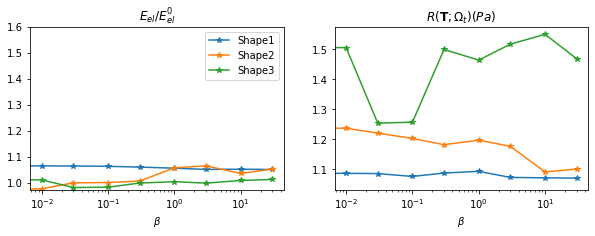

In [18]:
fig = plt.figure(figsize=(10, 3)); ax0 = fig.add_subplot(121); ax1 = fig.add_subplot(122, sharex=ax0);
for i in range(len(slist)):
    # print(shape_reslist[i][..., 3].flatten(), shape_reslist[i][0, 0, 3])
    ax0.semilogx(glist, shape_reslist[i][..., 3].flatten()/shape_reslist[i][0, 0, 3], '-*', label='Shape%d'%slist[i])
    ax1.semilogx(glist, shape_reslist[i][..., 2].flatten(), '-*', label='Shape%d'%slist[i])
ax0.legend(ncol=1); ax0.set_ylim(top=1.6)
ax0.set_title('$E_{el}/E_{el}^0$'); 
ax1.set_title(r'$R({\bf{T}};\Omega_t)(Pa)$');
ax0.set_xlabel(r'$\beta$'); ax1.set_xlabel(r'$\beta$')
plt.show()

In [19]:
savemat('Case05_summary_beta.mat', {'beta': glist,
                                    'Eel' : np.array(shape_reslist)[:, ..., 3],
                                    'Tres': np.array(shape_reslist)[:, ..., 2]})